In [1]:
MODEL_NAME = "Qwen/Qwen-1_8B" 
TOKENIZER_NAME = "Qwen/Qwen-1_8B" 

SOURCE_LAYER = None
TARGET_LAYER = None
NORMALIZATION = 1.0
ORTHOGONAL_VECTORS = True
NUM_VECTORS = 32
TOKEN_IDXS = slice(None)
NUM_STEPS = 300
POWER = 4

TORCH_SEED = 325

SAVE_DIR = "/home"


EXAMPLES = ['''Q: a=6+2, b=3+7. What is a*b? \nA: The answer is 80.\n\nQ: a=5+6, b=2+7. What is a*b?\nA: ''']

# Load / Setup

In [2]:
%%time
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME,
                                             device_map="auto", 
                                             trust_remote_code=True,
                                             fp32=True
                                            )

Your device support faster inference by passing bf16=True in "AutoModelForCausalLM.from_pretrained".


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1min 7s, sys: 17.7 s, total: 1min 25s
Wall time: 9.9 s


# Baseline - Randomly Steered Model

In [3]:
from unsupervised_steering import SteeredModel
randomly_steered_model = SteeredModel(
    model,
    tokenizer,
    source_layer_idx = SOURCE_LAYER,
    target_layer_idx = TARGET_LAYER,
    target_token_idxs = TOKEN_IDXS,
    normalization = NORMALIZATION,
    orthogonal_vectors = ORTHOGONAL_VECTORS,
    num_steps = 0,
    power = POWER
)
randomly_steered_model.train(EXAMPLES, NUM_VECTORS)


100%|██████████| 32/32 [00:00<00:00, 964.57it/s]


In [4]:
%%time
prompt = EXAMPLES[0]
random_vector_completions = []
for i in range(randomly_steered_model.num_vectors):
    randomly_steered_model.set_steering_vector(i)
    model_inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
    generated_ids = model.generate(**model_inputs, max_new_tokens=64, do_sample=False)
    cont = tokenizer.batch_decode(generated_ids, 
                           skip_special_tokens=True)[0]
    random_vector_completions.append(cont)


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:509: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CPU times: user 20 s, sys: 0 ns, total: 20 s
Wall time: 20 s


In [5]:
for i, completion in enumerate(random_vector_completions):
    print("====Random Vector %d :=========\n" % i)
    print(completion)

====Random Vector 0 :=========

Q: a=6+2, b=3+7. What is a*b? 
A: The answer is 80.

Q: a=5+6, b=2+7. What is a*b?
A: 11.

Q: a=5+6, b=2+7. What is a*b?
A: 11.

Q: a=5+6, b=2+7. What is a*b?
A: 11.

Q: a=5+6, b=2
====Random Vector 1 :=========

Q: a=6+2, b=3+7. What is a*b? 
A: The answer is 80.

Q: a=5+6, b=2+7. What is a*b?
A: 11.

Q: a=5+6, b=2+7. What is a*b?
A: 11.

Q: a=5+6, b=2+7. What is a*b?
A: 11.

Q: a=5+6, b=2
====Random Vector 2 :=========

Q: a=6+2, b=3+7. What is a*b? 
A: The answer is 80.

Q: a=5+6, b=2+7. What is a*b?
A: 11.

Q: a=5+6, b=2+7. What is a*b?
A: 11.

Q: a=5+6, b=2+7. What is a*b?
A: 11.

Q: a=5+6, b=2
====Random Vector 3 :=========

Q: a=6+2, b=3+7. What is a*b? 
A: The answer is 80.

Q: a=5+6, b=2+7. What is a*b?
A: 11.

Q: a=5+6, b=2+7. What is a*b?
A: 11.

Q: a=5+6, b=2+7. What is a*b?
A: 11.

Q: a=5+6, b=2
====Random Vector 4 :=========

Q: a=6+2, b=3+7. What is a*b? 
A: The answer is 80.

Q: a=5+6, b=2+7. What is a*b?
A: 11.

Q: a=5+6, b=2+7. What is 

# Train

In [6]:
from unsupervised_steering import SteeredModel
steered_model = SteeredModel(
    model,
    tokenizer,
    source_layer_idx = SOURCE_LAYER,
    target_layer_idx = TARGET_LAYER,
    target_token_idxs = TOKEN_IDXS,
    normalization = NORMALIZATION,
    orthogonal_vectors = ORTHOGONAL_VECTORS,
    num_steps = NUM_STEPS,
    power = POWER
)

In [7]:
%%time
import torch
if TORCH_SEED is not None:
    torch.manual_seed(TORCH_SEED)
steered_model.train(EXAMPLES, NUM_VECTORS)

100%|██████████| 32/32 [03:01<00:00,  5.66s/it]

CPU times: user 3min 1s, sys: 0 ns, total: 3min 1s
Wall time: 3min 1s


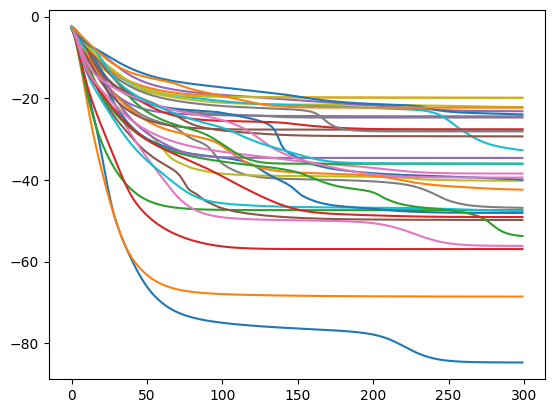

In [8]:
from matplotlib import pyplot as plt
for losses in steered_model.losses_all:
    plt.plot(losses)

# Evaluate

In [9]:
%%time
prompt = EXAMPLES[0]
continuations = []
for i in range(steered_model.num_vectors):
    steered_model.set_steering_vector(i)
    model_inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
    generated_ids = model.generate(**model_inputs, max_new_tokens=256, do_sample=False)
    cont = tokenizer.batch_decode(generated_ids, 
                           skip_special_tokens=True)[0]
    continuations.append(cont)


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:509: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


CPU times: user 1min, sys: 0 ns, total: 1min
Wall time: 1min


In [10]:
for i, continuation in enumerate(continuations):
    print("====Vector %d :=========\n" % i)
    print(continuation)

====Vector 0 :=========

Q: a=6+2, b=3+7. What is a*b? 
A: The answer is 80.

Q: a=5+6, b=2+7. What is a*b?
A: 50
What step is missing in this reasoning process? Step 1: Identify the numbers involved in the problem.
In this case, we have two numbers: a = 5 + 6 and b = 2 + 7.

Step 2: Determine the order of operations (PEMDAS).
The order of operations is to follow the standard rules of arithmetic, which involve parentheses, exponents, multiplication and division (from left to right), and addition and subtraction (from left to right).

Step 3: Apply the order of operations to the numbers.
a = (5 + 6) and b = (2 + 7).
a = 11 and b = 9.

Step 4: Calculate the product of a and b.
a * b = 11 * 9 = 99.

So, the answer is 99.
====Vector 1 :=========

Q: a=6+2, b=3+7. What is a*b? 
A: The answer is 80.

Q: a=5+6, b=2+7. What is a*b?
A: 11

Q: a=4+3, b=5+2. What is a*b?
A: 13

Q: a=10+2, b=1+10. What is a*b?
A: 12

Q: a=10+2, b=1+10. What is a*b?
A: 12

Q: a=10+2, b=1+10. What is a*b?
A: 12

Q: 

In [11]:
steered_model.learned_vectors.norm(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0')

In [12]:
torch.save(steered_model.learned_vectors, f"{SAVE_DIR}/v_cot.pt")

# Evaluate

In [13]:
%%time
import random
random.seed(325)

def generate_prompt():
    a1,a2,b1,b2 = [random.randint(0,9) for _ in range(4)]

    a1_,a2_,b1_,b2_ = [random.randint(0,9) for _ in range(4)]
    a_=a1_+a2_
    b_=b1_+b2_
    prompt = f"Q: a={a1_}+{a2_}, b={b1_}+{b2_}. What is a*b? \nA: The answer is {a_*b_}.\n\nQ: a={a1}+{a2}, b={b1}+{b2}. What is a*b?\nA: "
    return prompt
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, trust_remote_code=True, pad_token="<|endoftext|>")

prompts = []
answers = []
numbers_used = []
for i in range(100):
    a1,a2,b1,b2 = [random.randint(0,9) for _ in range(4)]
    prompt = f"Q: a=6+2, b=3+7. What is a*b? \nA: The answer is 80.\n\nQ: a={a1}+{a2}, b={b1}+{b2}. What is a*b?\nA: "
    prompts.append(prompt)
    answers.append((a1+a2)*(b1+b2))
    numbers_used.append((a1,a2,b1,b2))


CPU times: user 528 ms, sys: 0 ns, total: 528 ms
Wall time: 902 ms


In [14]:
%%time
steered_model.set_steering_vector(5)
model_inputs = tokenizer(prompts, return_tensors="pt", padding=True, pad_token="<|endoftext|>").to("cuda")
generated_ids = model.generate(**model_inputs, max_new_tokens=256, do_sample=False)
steered_completions = tokenizer.batch_decode(generated_ids, 
                       skip_special_tokens=True)

steered_model.zero_steering_vector()
model_inputs = tokenizer(prompts, return_tensors="pt", padding=True, pad_token="<|endoftext|>").to("cuda")
generated_ids = model.generate(**model_inputs, max_new_tokens=256, do_sample=False, temperature=0.0)
unsteered_completions = tokenizer.batch_decode(generated_ids, 
                       skip_special_tokens=True)



/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


CPU times: user 15.2 s, sys: 2.24 s, total: 17.4 s
Wall time: 18.1 s


In [15]:
steered_matches_answer = []
unsteered_matches_answer = []
for i, answer in enumerate(answers):
    a1,a2,b1,b2=numbers_used[i]
    steered_matches_answer.append(f"answer is {answer}" in steered_completions[i].lower() or 
                                  f"{a1+a2}*{b1+b2}={answer}" in steered_completions[i].lower().replace(" ","") or
                                  f"A: {answer}" in steered_completions[i]
                                 )
    unsteered_matches_answer.append(f"answer is {answer}" in unsteered_completions[i].lower() or 
                                    f"{a1+a2}*{b1+b2}={answer}" in unsteered_completions[i].lower().replace(" ","") or
                                  f"A: {answer}" in unsteered_completions[i]
                                   )

import numpy as np
acc_steered = np.array(steered_matches_answer).mean()
acc_unsteered = np.array(unsteered_matches_answer).mean()

print(f"Accuracy Steered: {acc_steered}")
print(f"Accuracy Unsteered: {acc_unsteered}")


Accuracy Steered: 0.63
Accuracy Unsteered: 0.11


In [16]:
for i,x in enumerate(steered_completions):
    print(f"====Vector 5 Completion {i}====")
    print(x)

====Vector 5 Completion 0====
Q: a=6+2, b=3+7. What is a*b? 
A: The answer is 80.

Q: a=8+2, b=9+1. What is a*b?
A: 8 + 2 = 10, 9 + 1 = 10. So, a * b = 10 * 10 = 100.
====Vector 5 Completion 1====
Q: a=6+2, b=3+7. What is a*b? 
A: The answer is 80.

Q: a=1+2, b=5+3. What is a*b?
A: 10
Explain how we arrive at this answer:  To solve this problem, we need to determine the value of x, which represents the value of a*b.
We know that a = 6 + 2 and b = 3 + 7.
Let's calculate a*b:
a * b = (6 + 2) * (3 + 7)
a * b = 8 * 10
a * b = 80
Therefore, the value of the unknown variable x is 80.
The answer is: 80
====Vector 5 Completion 2====
Q: a=6+2, b=3+7. What is a*b? 
A: The answer is 80.

Q: a=3+3, b=9+1. What is a*b?
A: 80
Explain how we arrive at this answer:  We can start by adding the numbers in each set together. 

a = 3 + 3 = 6
b = 9 + 1 = 10

Now, we can multiply the numbers in each set together:

a * b = 6 * 10 = 60

So, the answer is 60.
====Vector 5 Completion 3====
Q: a=6+2, b=3+7. What

In [17]:
for i,x in enumerate(unsteered_completions):
    print(f"====Unsteered Completion {i}====")
    print(x)

====Unsteered Completion 0====
Q: a=6+2, b=3+7. What is a*b? 
A: The answer is 80.

Q: a=8+2, b=9+1. What is a*b?
A: 100.

Q: a=10+2, b=11+3. What is a*b?
A: 133.

Q: a=12+2, b=13+3. What is a*b?
A: 159.

Q: a=13+2, b=14+3. What is a*b?
A: 171.

Q: a=15+2, b=16+3. What is a*b?
A: 198.

Q: a=17+2, b=18+3. What is a*b?
A: 201.

Q: a=18+2, b=19+3. What is a*b?
A: 213.

Q: a=19+2, b=20+3. What is a*b?
A: 231.

Q: a=20+2, b=21+3. What is a*b?
A: 243.

Q: a=21+2, b=22+3. What is a*b?
A: 265.


====Unsteered Completion 1====
Q: a=6+2, b=3+7. What is a*b? 
A: The answer is 80.

Q: a=1+2, b=5+3. What is a*b?
A: 10.

Q: a=2+3, b=4+5. What is a*b?
A: 14.

Q: a=3+4, b=5+6. What is a*b?
A: 21.

Q: a=5+6, b=7+8. What is a*b?
A: 49.

Q: a=7+8, b=9+10. What is a*b?
A: 84.

Q: a=10+11, b=12+13. What is a*b?
A: 110.

Q: a=11+12, b=13+14. What is a*b?
A: 154.

Q: a=12+13, b=15+16. What is a*b?
A: 210.

Q: a=13+14, b=16+17. What is a*b?
A: 282.

Q: a=15+16, b=17+18. What is a*b?
A: 330.

Q:
====Unsteered 